In [603]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [604]:
def plot_background_fct(send_data, recv_data, label, do_plot=True):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Background FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [605]:
def plot_foreground_fct(send_data, recv_data, label, do_plot=True):
    # diffs in micrseconds
    diffs = (recv_data - send_data) * 1000 * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Foreground FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Microseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [606]:
def plot_fanout(send_data, recv_data, label, do_plot=True, res_type="max"):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if res_type=="max":
        diffs = np.max(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="avg":
        diffs = np.mean(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="min":
        diffs = np.min(diffs[:,:diffs.shape[1]-1],1)
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="RCT"+label) 
        ax1.set_title("Partition/Aggregate query completion time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Query ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [607]:
def servers_within_deadline(send_data, recv_data, deadline = 20):
    # diffs and deadline in miliseconds
    diffs = (recv_data - send_data) * 1000.0
    diffs_within_deadline = diffs < deadline
    num_serv_that_meet_deadline = np.sum(diffs_within_deadline,1)
    print(num_serv_that_meet_deadline.shape)
    num_serv_that_meet_deadline = np.sort(num_serv_that_meet_deadline, axis=0)
    end = int(np.round(0.01*num_serv_that_meet_deadline.shape[0]))
    print(end)
    res_99 = np.mean(num_serv_that_meet_deadline[:end])
    print(num_serv_that_meet_deadline[:end])
    return np.mean(num_serv_that_meet_deadline), res_99

In [608]:
a = np.array([[1,2,3,4,5,1,7],[2,4,7,1,8,4,1,]])
b=a<4
print(b)
c = np.sum(b,1)
print(c)

[[ True  True  True False False  True False]
 [ True False False  True False False  True]]
[4 3]


In [609]:
def plot_queue_size(data, label, do_plot=True):
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [610]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    results in microseconds
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing microseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [611]:
def print_results(fore=True, back=True, fanout_max=True, fanout_avg=True, fanout_min=True):
    print("Mean Q length in Kbytes {0} and in packets {1}\n99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}\n".format(delay_mean, delay_99))
    if fore:
        print("Foreground FCT (us): mean: {0}, 99th %: {1}\n".format(frg_mean, frg_99))
    if back:
        print("Background FCT (ms): mean: {0}, 99th %: {1}\n".format(bkg_mean, bkg_99))
    if fanout_max:
        print("Fanout max QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_max_mean, fan_max_99))
    if fanout_avg:
        print("Fanout avg QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_avg_mean, fan_avg_99))
    if fanout_min:
        print("Fanout min QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_min_mean, fan_min_99))
        print("Servers in deadline: mean: {0}, 99th %: {1}\n".format(servers_mean, servers_99))
        
    
    
    #print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

## Just fanout, workload 1 at 30% - 10 flows

In [612]:
results_folders = ["/TCP/", "/DCTCP30/", "/DCTCP_pacer_PQ/"]
latency = dict()
bkg_fct = dict()
frg_fct = dict()
fanout_qct_max = dict()
fanout_qct_avg = dict()
fanout_qct_min = dict()
servers_in_deadline = dict()

deadline = 25


for folder in results_folders:
    latency[folder] = []
    bkg_fct[folder] = []
    frg_fct[folder] = []
    fanout_qct_max[folder] = []
    fanout_qct_avg[folder] = []
    fanout_qct_min[folder] = []    
    servers_in_deadline[folder] = []        

In [613]:
simul_folder = "onlyfanout_wkld1_30_10flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=False, fanout_max=True, fanout_avg=True, fanout_min=True)
    
    """
    (0,1484)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,0)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1281)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,0)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(11855,)
119
[7 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9]
/TCP/
Mean Q length in Kbytes 0.0015321006270788598 and in packets 0.0027573506010255544
99th percentile in Kbytes 0.011477501352366208 and in packets 0.01855625382818478

Mean delay in us 0.012256805016630878 and 99th percentile delay in us 0.09182001081892967

Fanout max QCT (ms): mean: 11.861691827033336, 99th %: 30.592449654056097

Fanout avg QCT (ms): mean: 4.1467681495415905, 99th %: 10.337442728251556

Fanout min QCT (ms): mean: 0.6328319526961736, 99th %: 2.820076103245623

Servers in deadline: mean: 9.966090257275411, 99th %: 8.882352941176471

(11855,)
119
[7 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 

## Fanout, workload 1 at 30% + background traffic at 200Mbps - 10 flows 

In [614]:
simul_folder = "bkg200_fanout_wkld1_30_10flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,1695)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,12071)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1396)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,40)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(11855,)
119
[7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9]
/TCP/
Mean Q length in Kbytes 24.628110090979828 and in packets 25.768533059783728
99th percentile in Kbytes 267.3721422728311 and in packets 279.7298486201625

Mean delay in us 197.02488072783862 and 99th percentile delay in us 2138.9771381826495

Background FCT (ms): mean: 109.92766356092046, 99th %: 318.0634533299275

Fanout max QCT (ms): mean: 12.549892728325995, 99th %: 31.821353152573664

Fanout avg QCT (ms): mean: 4.792751314334563, 99th %: 12.895179087839015

Fanout min QCT (ms): mean: 1.216873200571218, 99th %: 7.194570282529608

Servers in deadline: mean: 9.95520877266976, 99th %: 8.714285714285714

(11855,)
119
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 

## Fanout, workload 1 at 30% + background traffic at 400Mbps - 10 flows 

In [615]:
simul_folder = "bkg400_fanout_wkld1_30_10flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2128)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,41889)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1680)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,86)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(11855,)
119
[5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9
 9 9 9 9 9 9 9 9]
/TCP/
Mean Q length in Kbytes 75.06456829547504 and in packets 78.48438846994496
99th percentile in Kbytes 411.01618757177755 and in packets 430.8608972021599

Mean delay in us 600.5165463638003 and 99th percentile delay in us 3288.1295005742204

Background FCT (ms): mean: 165.33481664007627, 99th %: 817.3233540886029

Fanout max QCT (ms): mean: 13.803090384736112, 99th %: 34.860641161528726

Fanout avg QCT (ms): mean: 6.046484334261797, 99th %: 16.89829727515472

Fanout min QCT (ms): mean: 2.418914480344879, 99th %: 11.25206169148547

Servers in deadline: mean: 9.926022775200337, 99th %: 7.714285714285714

(11855,)
119
[7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 

## Fanout, workload 1 at 30% + background traffic at 600Mbps - 10 flows 

In [616]:
simul_folder = "bkg600_fanout_wkld1_30_10flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2553)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,90697)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1870)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,94)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(11855,)
119
[1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7]
/TCP/
Mean Q length in Kbytes 137.4988512931009 and in packets 143.69340675134055
99th percentile in Kbytes 446.4897339600699 and in packets 466.0721314111673

Mean delay in us 1099.9908103448072 and 99th percentile delay in us 3571.9178716805595

Background FCT (ms): mean: 246.1437467003578, 99th %: 1213.8932086380803

Fanout max QCT (ms): mean: 16.35362364816382, 99th %: 52.98476515080792

Fanout avg QCT (ms): mean: 7.909751940638971, 99th %: 22.7230888511762

Fanout min QCT (ms): mean: 3.963092578555737, 99th %: 14.680910090607732

Servers in deadline: mean: 9.81383382539013, 99th %: 5.563025210084033

(11855,)
119
[7 7 7 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 

In [617]:
print("--------latency----------")
print(latency)
print("--------bkg----------")
print(bkg_fct)
print("--------fan_max----------")
print(fanout_qct_max)
print("--------fan_avg---------")
print(fanout_qct_avg)
print("--------fan_min---------")
print(fanout_qct_min)
print("--------quality---------")
print(servers_in_deadline)


--------latency----------
{'/TCP/': [(0.012256805016630878, 0.09182001081892967), (197.02488072783862, 2138.9771381826495), (600.5165463638003, 3288.1295005742204), (1099.9908103448072, 3571.9178716805595)], '/DCTCP30/': [(0.012256805016630878, 0.09182001081892967), (28.53995151670976, 164.87210912499066), (61.73184791679115, 166.40192398614258), (93.74407769135765, 166.58410213866435)], '/DCTCP_pacer_PQ/': [(0.011402435507357337, 0.07736876960638275), (0.6277829051128065, 15.210358573679539), (6.562917157643957, 94.21613227324963), (23.815267131677725, 125.34656354258397)]}
--------bkg----------
{'/TCP/': [(109.92766356092046, 318.0634533299275), (165.33481664007627, 817.3233540886029), (246.1437467003578, 1213.8932086380803)], '/DCTCP30/': [(114.41642104599012, 280.4406935408957), (180.03476141662125, 844.8018376829639), (269.50307225310854, 1293.8886469157196)], '/DCTCP_pacer_PQ/': [(243.65444273656223, 367.2316272451263), (320.1228890368373, 872.6280600159371), (430.5696625523043, 

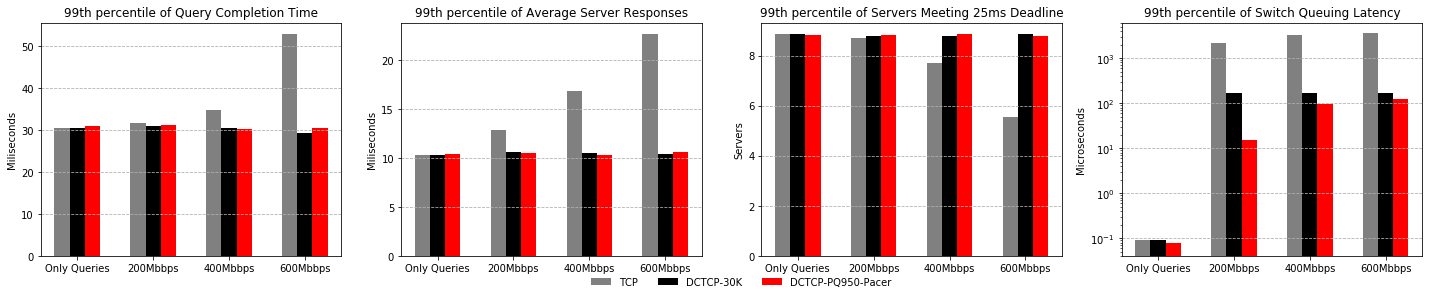

In [640]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
config_num = 4
ind = np.arange(config_num)
width = 0.2
x_axis_labels = ('Only Queries', '200Mbbps', '400Mbbps', '600Mbbps')
# qct max
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_max[folder]])
p1 = ax1.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax1.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax1.bar(ind+1.5*width, res[2], width, color='r')


ax1.set_title('99th percentile of Query Completion Time')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(x_axis_labels)
# ax1.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
ax1.set_ylabel('Miliseconds')
ax1.yaxis.grid(linestyle="--")


# qct avg
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_avg[folder]])
p1 = ax2.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax2.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax2.bar(ind+1.5*width, res[2], width, color='r')


ax2.set_title('99th percentile of Average Server Responses')
ax2.set_xticks(ind + width / 2)
ax2.set_xticklabels(x_axis_labels)
# ax2.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
ax2.set_ylabel('Miliseconds')
ax2.yaxis.grid(linestyle="--")


# Quality
res = []
for folder in results_folders:
    res.append([x[1] for x in servers_in_deadline[folder]])
p1 = ax3.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax3.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax3.bar(ind+1.5*width, res[2], width, color='r')


ax3.set_title('99th percentile of Servers Meeting 25ms Deadline')
ax3.set_xticks(ind + width / 2)
ax3.set_xticklabels(x_axis_labels)
# ax3.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='lower left')
ax3.set_ylabel('Servers')
ax3.yaxis.grid(linestyle="--")



# Switch Latency
res = []
for folder in results_folders:
    res.append([x[1] for x in latency[folder]])
p1 = ax4.bar(ind-0.5*width, res[0], width, color='grey',log=True)
p2 = ax4.bar(ind+0.5*width, res[1], width, color='k',log=True)
p3 = ax4.bar(ind+1.5*width, res[2], width, color='r',log=True)


ax4.set_title('99th percentile of Switch Queuing Latency')
ax4.set_xticks(ind + width / 2)
ax4.set_xticklabels(x_axis_labels)
# ax4.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='lower right')
ax4.set_ylabel('Microseconds')
ax4.yaxis.grid(linestyle="--")

fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.41,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()

In [ ]:
# fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,10))
# for i, setup in enumerate(results_folders):
#     ax1.bar(i-0.4, latency[setup][0][0], width=0.1, log=True, color="blue")
#     ax1.bar(i-0.3, latency[setup][0][1], width=0.1, log=True, color="blue")
#     ax1.bar(i-0.1, latency[setup][1][0], width=0.1, log=True, color="red")
#     ax1.bar(i, latency[setup][1][1], width=0.1, log=True, color="red")
#     ax1.bar(i+0.2, latency[setup][2][0], width=0.1, log=True, color="green")
#     ax1.bar(i+0.3, latency[setup][2][1], width=0.1, log=True, color="green")
# ax1.set_title("Switch Latency")
# ax1.legend(loc='upper left')
# ax1.set_ylabel('Queuing miliseconds')
# ax1.set_xlabel('Scheme')
# ax1.grid(which='major', linestyle="-")
# #ax1.grid(which='minor', linestyle='--')

# fig.tight_layout()   

# fig.savefig("Queuing delay vs Time.png", format="png")
# fig.show()